Analysis of the LFPs in response to photostimulation

This notebook (LFP_Analysis_part2) follows the following pipeline:

1. Selection of an animal
2. Read processed data (LFP_Analysis_part1) from all sessions
3. Selection of an electrode
4. Normalization of the average traces
5. Plot the LFP slope over sessions

The code performs sanity checks and saves plots to illustrate the process


In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import os
import glob
import ntpath
import matplotlib.pylab as plt
import math
import matplotlib
%matplotlib inline
from utils.custom_functions import *
from scipy.signal import find_peaks
import sys
sys.path.append("../") # go to parent 
from BehaviouralAnalysis.utils.plot_utils import axvlines
import quantities as pq
import pdb

In [23]:
# 1 and 2. Selection of an animal and retrieval of data
AnimalID = 'Red'
GeneralDataDir = '/mnt/c/Users/herny/Desktop/SWC/Data/Ephys_data/LFP_Recordings/'
# Load those pickle files that correspond to the animal and that are from Analysis part 1
SessionsAverages = [] # to store the data
SessionsTimes = [] # times associated with the alignment
FileNames = [] # to store experiment names
for file in glob.glob(GeneralDataDir+AnimalID+'*AnalysisPart_1/*.pkl'):
    with open(file, 'rb') as f:
        Interval_Times, Average_Traces = pickle.load(f)
        SessionsAverages.append(Average_Traces)
        SessionsTimes.append(Interval_Times)
    FileNames.append(ntpath.basename(file))
    print('Read {}'.format(ntpath.basename(file)))

# Create output folder to save data
OutPutDir = GeneralDataDir + AnimalID + '_AnalysisPart_2/'
if not os.path.isdir(OutPutDir):
    os.mkdir(OutPutDir)

# Parse titles 
FilesDates = parseTitlesForDates(FileNames)
TrainingProtocol = parseTitlesForProtocol(FileNames)
ShortFileNames = [AnimalID + '_' + FilesDates[x] + '_' + TrainingProtocol[x] for x in range(len(FileNames))]


Read Red_2019-04-03_16-51-05_LFP_baseline_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-04_15-05-56_LFP_baseline_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-05_15-49-01_LFP_habituation_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-06_14-47-39_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-07_12-41-59_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-08_11-26-18_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-09_16-29-53_LFP_visualNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-10_18-31-30_LFP_visualPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-11_17-27-31_LFP_visualPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-12_18-01-20_LFP_visualPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-13_11-36-29_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-14_14-04-42_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-15_14-04-26_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-16_11-36-49_LFP_auditNoPun_2.5mW_Analysis-1-data.pkl
Read Red_2019-04-17_11

Progress: [####################] 97.7%


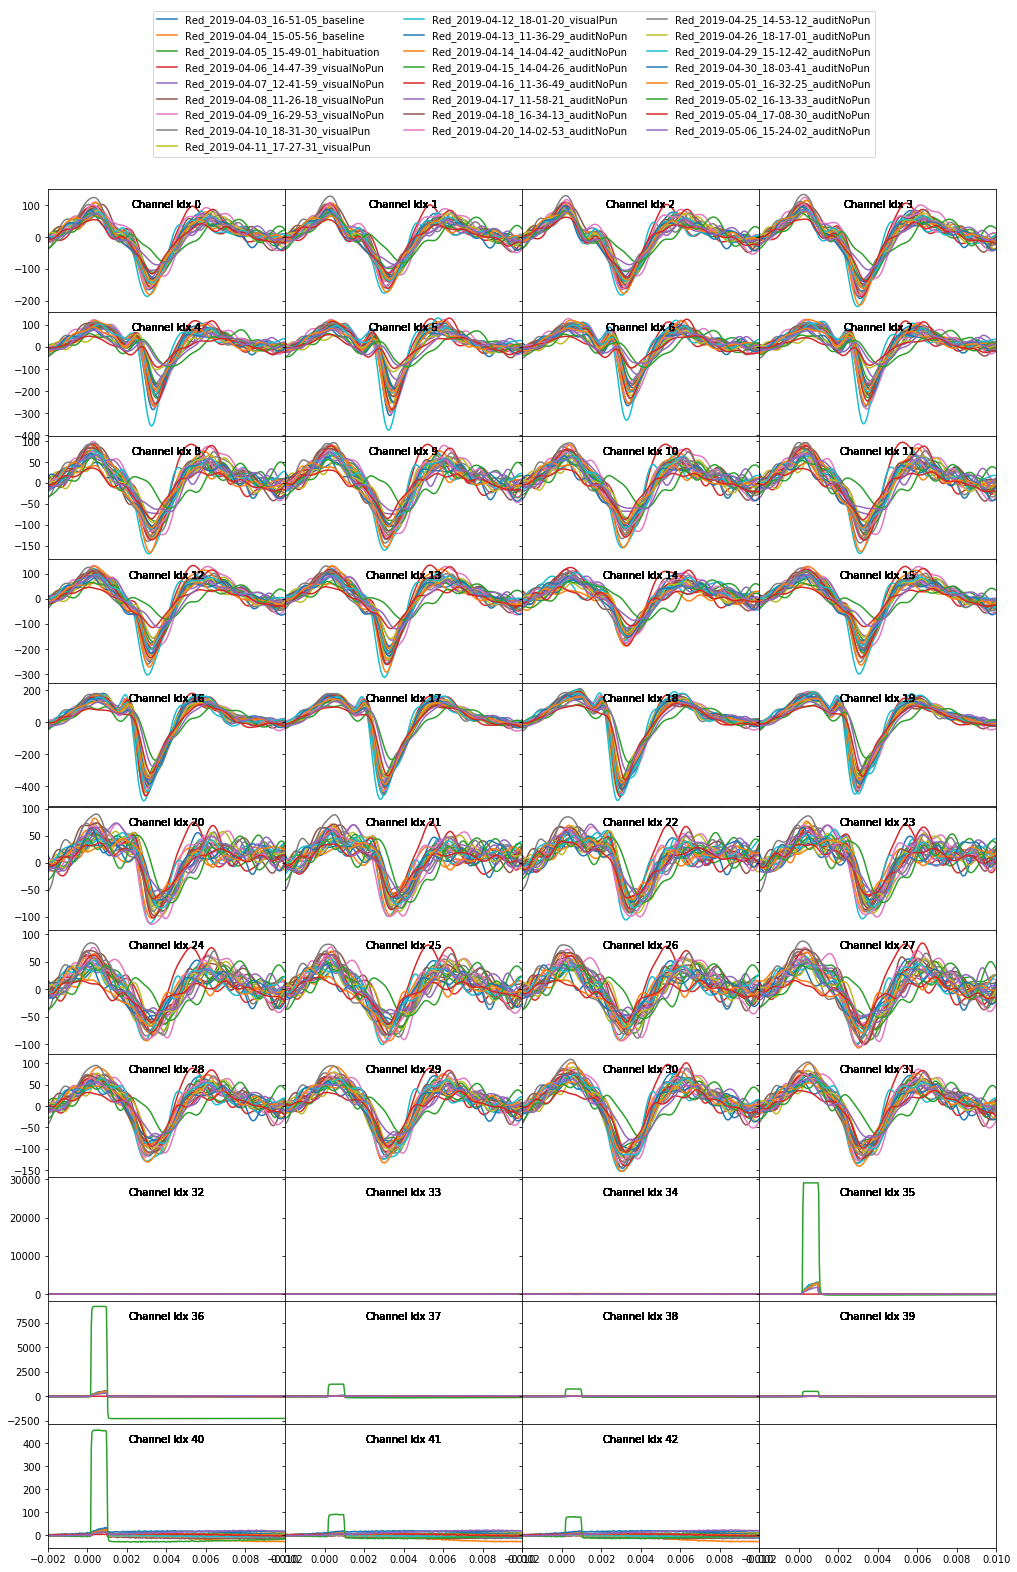

In [24]:
# For each of the channels, plot how the align data looks over experiments
fig, axs = plt.subplots(math.ceil(len(SessionsAverages[0])/4), 4, figsize=(17, 25), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#plt.suptitle(AnimalID, y=0.9, x=0.15)
for j in range(len(SessionsAverages[0])):
    for i in range(len(SessionsAverages)):
        axs[j].plot(SessionsTimes[i], SessionsAverages[i][j], label = ShortFileNames[i])
        axs[j].set_xlim(-0.002, 0.01)
        #axvlines(0, ax=axs[j])
        axs[j].text(.5,.85,"Channel Idx " + str(j), horizontalalignment='center', transform=axs[j].transAxes)
        update_progress(j / len(SessionsAverages[0]))
handles, labels = axs[j].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.15,0.90), ncol=3)
#plt.show()
fig.savefig(OutPutDir + 'ChannelsSummary.pdf', transparent=True)

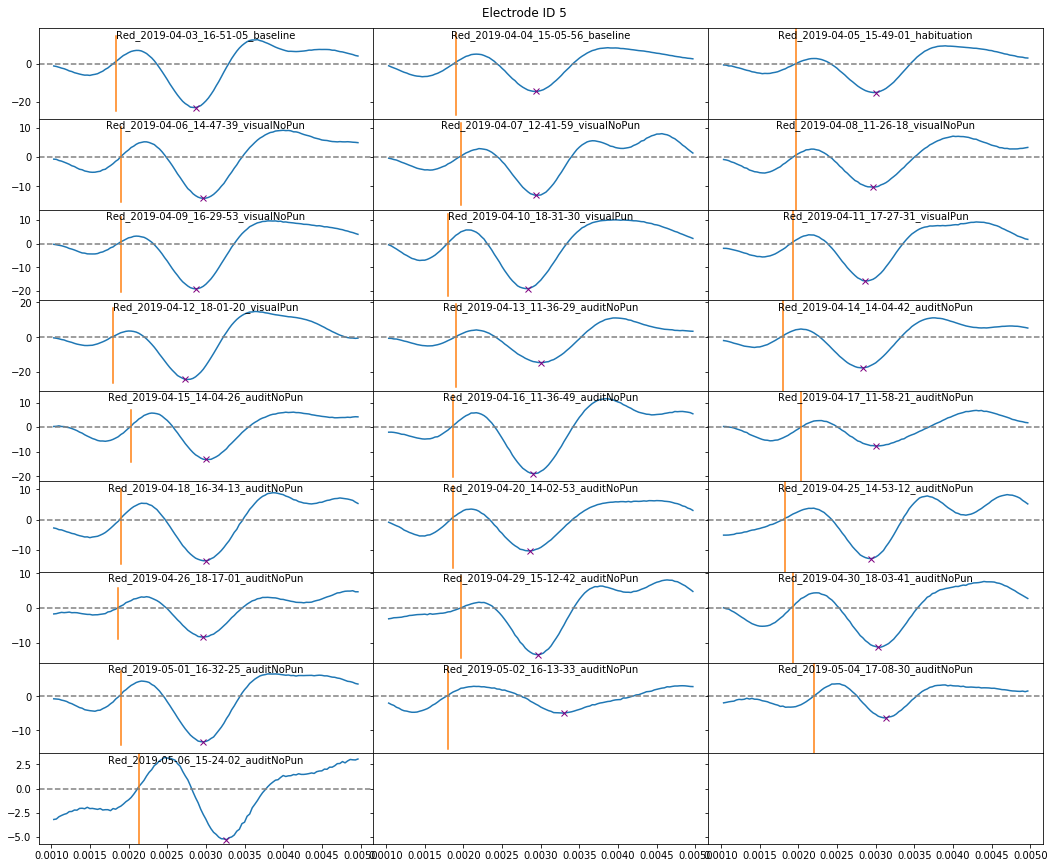

In [30]:
# Now, select an electrode, find the derivative and other features and check correlations
ElectrodeID = 5

# Restart lists (necesary if running this again after the cells below)
FilesDates = parseTitlesForDates(FileNames)
TrainingProtocol = parseTitlesForProtocol(FileNames)
ShortFileNames = [AnimalID + '_' + FilesDates[x] + '_' + TrainingProtocol[x] for x in range(len(FileNames))]

# define a window of the LFP shape
LFPwindow = [0.001, 0.005]

# Get the data for the electrode for the LFP frames
ElectrodeLFPData = []
ElectrodeLFPTimes = []
for j in range(len(SessionsAverages)):
    LFPframes = np.logical_and(SessionsTimes[j]>=LFPwindow[0], SessionsTimes[j]<=LFPwindow[1])
    ElectrodeLFPData.append(SessionsAverages[j][ElectrodeID][LFPframes])
    ElectrodeLFPTimes.append(SessionsTimes[j][LFPframes])

Derivatives = np.diff(ElectrodeLFPData, axis = 1)
    
# for the minima of the ChR2 bump, find the first ascending 0 cross of the derivative
MinChR2List = []
MinChR2ListIdx = []
MinChR2ListTime = []
for j in range(len(Derivatives)):
    for i in range(len(Derivatives[j])):
        if np.logical_and(Derivatives[j][i+1]>=0, Derivatives[j][i] < 0):
            MinChR2ListTime.append(ElectrodeLFPTimes[j][i+1])
            MinChR2List.append(ElectrodeLFPData[j][i+1])
            MinChR2ListIdx.append(i+1)
            break


# for the maximum slope of the LFP, find the biggest minima after that
DerMin = []
DerMinIdx = []
DerMinTime = []
for j in range(len(Derivatives)):
    peaks, _ = find_peaks(-1 * Derivatives[j])
    peaks = peaks[peaks>MinChR2ListIdx[j]]
    DerMin.append(np.min(Derivatives[j][peaks]))
    DerMinIdx.append(peaks[np.argmin(Derivatives[j][peaks])])
    DerMinTime.append(ElectrodeLFPTimes[j][DerMinIdx[j]])
    
    
fig, axs = plt.subplots(math.ceil(len(Derivatives)/3), 3, figsize=(18,15), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle('Electrode ID ' + str(ElectrodeID), y=0.9, x=0.5)
for j in range(len(Derivatives)):
    axs[j].plot(ElectrodeLFPTimes[j][:-1], Derivatives[j])
    axs[j].plot(DerMinTime[j], DerMin[j], "x", color = 'purple')
    #axs[j].plot(MinChR2ListTime[j], MinChR2List[j], "x", color = 'purple')
    axvlines(MinChR2ListTime[j], ax = axs[j])
    axs[j].axhline(0, color="gray", linestyle = '--')
    #axs[j].set_xlim(0.001, 0.002)
    axs[j].text(.5,.9,ShortFileNames[j], horizontalalignment='center', transform=axs[j].transAxes)

fig.savefig(OutPutDir + 'ChannelID-' + str(ElectrodeID) + '_derivatives.pdf', transparent=True)
plt.show()

In [31]:
# Remove experiments in which the shape is not correct
ExpToRemove = []
for j in range(len(MinChR2ListTime)):
    if MinChR2ListTime[j] > 0.0025:
        print(FileNames[j])
        ExpToRemove.append(j)
for index in sorted(ExpToRemove, reverse=True):
    del MinChR2List[index]
    del ShortFileNames[index]
    del DerMin[index]
    del FilesDates[index]
    del TrainingProtocol[index]


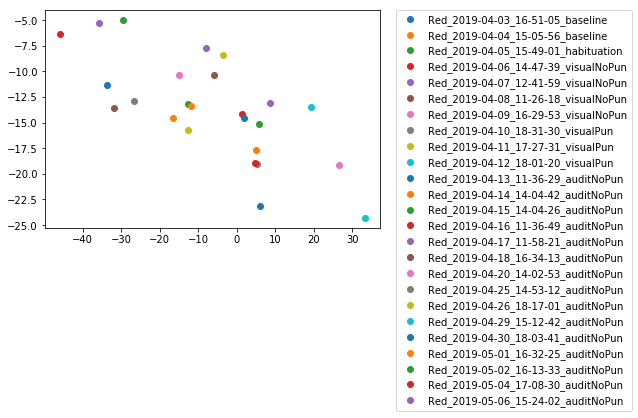

In [32]:
# plot correlation
for i in range(len(MinChR2List)):
    plt.plot(MinChR2List[i], DerMin[i], 'o', label = ShortFileNames[i])#, color = TrainingProtocol)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(OutPutDir + 'ChannelID-' + str(ElectrodeID) + '_correlations.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

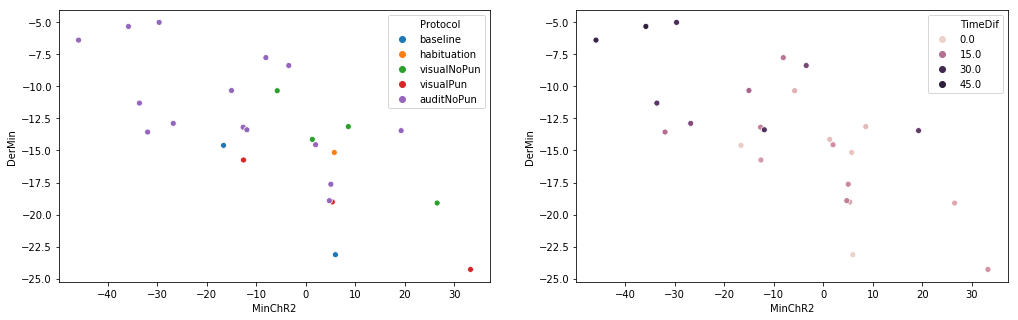

In [33]:
import seaborn as sns
expTimeDifferences = timeDifferences(FilesDates)

corrdf = pd.DataFrame({'SessionID': ShortFileNames,
                       'Protocol': TrainingProtocol,
                       'MinChR2': MinChR2List,
                       'DerMin': DerMin,
                       'TimeDif': expTimeDifferences})
fig, ax = plt.subplots(1,2,figsize=(17,5))
ax.ravel()
sns.scatterplot(x='MinChR2', y='DerMin', hue='Protocol', data=corrdf, ax=ax[0])
sns.scatterplot(x='MinChR2', y='DerMin', hue='TimeDif', data=corrdf, ax=ax[1])
plt.savefig(OutPutDir + 'ChannelID-' + str(ElectrodeID) + '_correlations_nicer.pdf', transparent=True,
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show(fig)

/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hmvergara/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Pas

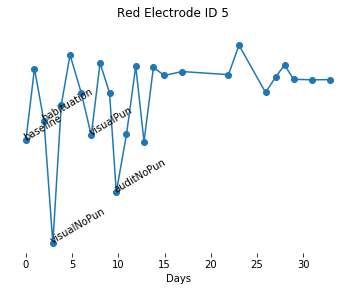

In [34]:
# plot relation of peaks across experiments
Relation = [DerMin[i] / MinChR2List[i] for i in range(len(DerMin))]
plt.plot(expTimeDifferences, Relation, 'o-')
plt.xlabel('Days')
plt.suptitle(AnimalID + ' Electrode ID ' + str(ElectrodeID))
#label the transitions
for j in range(len(set(TrainingProtocol))):
    idxOfTransition = next(x for x in range(len(TrainingProtocol)) if TrainingProtocol[x] == list(set(TrainingProtocol))[j])
    plt.text(expTimeDifferences[idxOfTransition], Relation[idxOfTransition], TrainingProtocol[idxOfTransition],
            rotation=30, rotation_mode='anchor')
plt.tick_params(top='off', bottom='on', left='off', right='off', labelleft='off', labelbottom='on')
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.savefig(OutPutDir + 'ChannelID-' + str(ElectrodeID) + '_LFP-changes.pdf', transparent=True)

In [8]:
MinChR2List

[148.90301075268817,
 204.64522222222226,
 162.59455555555553,
 197.59277777777777,
 154.01033333333334,
 109.32633333333334,
 189.88788888888894,
 173.04899999999998,
 288.464,
 248.73244444444444,
 198.22733333333338,
 121.62733333333333,
 147.45055555555552,
 136.3121111111111,
 191.73377777777782,
 188.0913333333333,
 154.72888888888883,
 72.20966666666668,
 51.166666666666664,
 62.335555555555544,
 65.18633333333334,
 22.577444444444446,
 29.991777777777767,
 0.7295555555555535]